In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import importlib
import download_clean_data as dc
import ipca
import metrics
import kernel_regression as kr
import validaton as val
import pickle
importlib.reload(dc) 
importlib.reload(ipca)
importlib.reload(metrics)
importlib.reload(kr)
importlib.reload(val)
sns.set(rc={'figure.figsize':(15,8)})

### Download data

In [15]:
folder_path = "/Users/matteoferrazzi/Documents/GitHub/ml-project-2-ml-project2-mma/Data/monthly_data"
N = 100
start_date = 20000000
ending_date = 20060000
data, ret = dc.download_clean_data(folder_path, start_date, ending_date,N)

### Plot to see how the models converge with the number of iterations

In [16]:
r2_ipca = []
r2_ipca_reg = []
r2_gaussian = []
r2_rq = []

#parameters 
k = 5
gamma_first = ipca.gamma_first(ret, data, k)
W = np.eye(N)
W_list = [W]*(len(data))
data2 = data.copy()
data2 = np.array(np.array(data2).reshape((len(data))*N,94)) #flatten data, build X
K_gaussian = kr.K_LR(data2, 1, 20)
K_rq = kr.K_LR(data2, 2, 20, 20)
_, f_list = ipca.ipca(data, ret, gamma_first.copy(), 1)
Omega1_inv=np.eye((len(data))*N)
Omega2_inv=np.eye(N)

#loop over the number of iterations
for i in np.arange(1,16,2):
    gamma, f_list = ipca.ipca(data, ret, gamma_first.copy(), i)
    r2_ipca.append(metrics.total_R_squared(ret, data, gamma, f_list))
    gamma_reg_w, f_list_reg_w = ipca.ipca_reg_w(data, ret, gamma_first.copy(), i, 0.01, 1000, W_list) 
    r2_ipca_reg.append(metrics.total_R_squared(ret, data, gamma_reg_w, f_list_reg_w))
    f_list_kr, v_kr, Q_kr, _, _ = kr.kernel_regression(data, ret, f_list.copy(), 0.01, 1, Omega1_inv, Omega2_inv, i, N, K_gaussian)
    r2_gaussian.append(metrics.total_R_squared_kr(ret, v_kr, Q_kr))
    f_list_kr, v_kr, Q_kr, _, _ = kr.kernel_regression(data, ret, f_list.copy(), 0.01, 1, Omega1_inv, Omega2_inv, i, N, K_rq)
    r2_rq.append(metrics.total_R_squared_kr(ret, v_kr, Q_kr))



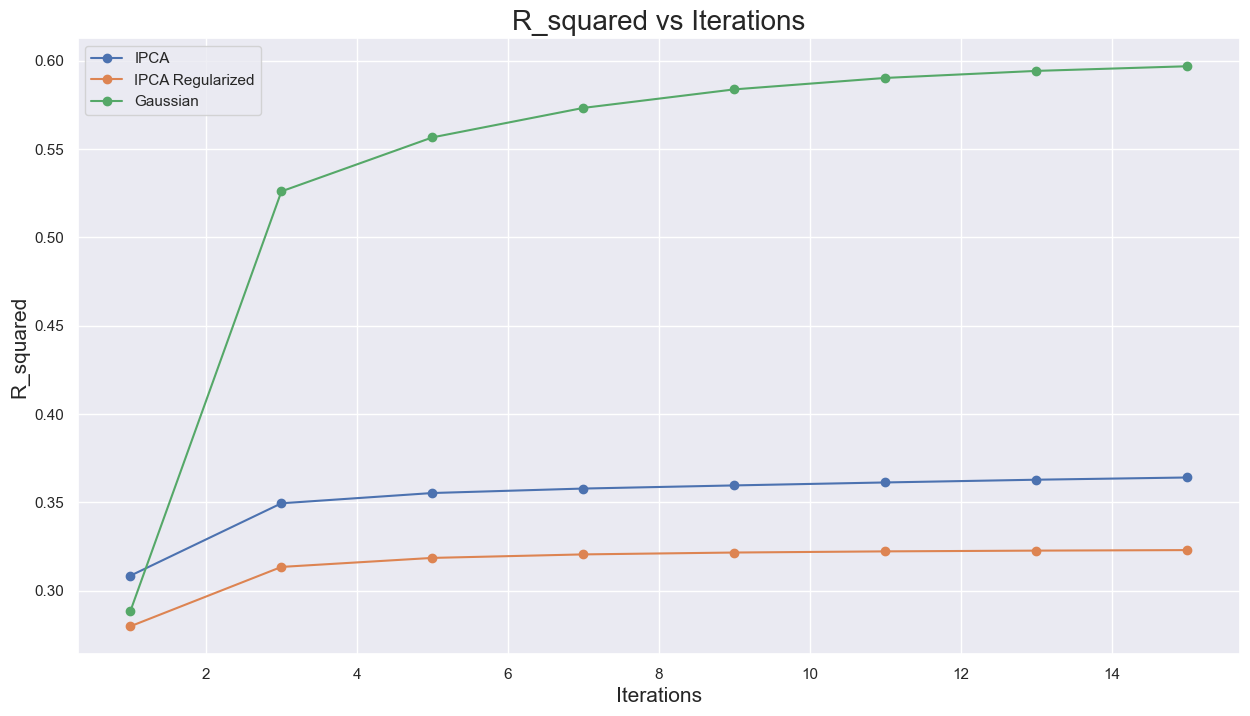

In [17]:
plt.plot(np.arange(1,16,2), r2_ipca, label = "IPCA", marker = "o")
plt.plot(np.arange(1,16,2), r2_ipca_reg, label = "IPCA Regularized", marker = "o")
plt.plot(np.arange(1,16,2), r2_gaussian, label = "Gaussian", marker = "o")
#plt.plot(np.arange(1,16,2), r2_rq, label = "Rational Quadratic", marker = "o") # equal to gaussian 
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('R_squared', fontsize=15)
plt.title('R_squared vs Iterations', fontsize=20)
plt.legend()

### Evaluation of different models and sanity check

In [18]:
#parameters 
k = 5
gamma_first = ipca.gamma_first(ret, data, k)  
max_iter = 100

#IPCA
gamma, f_list = ipca.ipca(data, ret, gamma_first.copy(), max_iter)
print('The R_squared of IPCA is : ',metrics.total_R_squared(ret, data, gamma, f_list),'The predictive R_squared of IPCA is : ',metrics.pred_R_squared(ret, data, gamma, f_list))

#parameters 
W = np.eye(N)
W_list = [W]*(len(data))
lambda1 = 0.01 
lambda2 = 1000 

#IPCA regularized
gamma_reg_w, f_list_reg_w = ipca.ipca_reg_w(data, ret, gamma_first.copy(), max_iter, lambda1, lambda2, W_list)
print('The R_squared of regularized IPCA is : ',metrics.total_R_squared(ret, data, gamma_reg_w, f_list_reg_w),'The predictive R_squared of regularized IPCA is : ',metrics.pred_R_squared(ret, data, gamma_reg_w, f_list_reg_w))

The R_squared of IPCA is :  0.366763508734967 The predictive R_squared of IPCA is :  0.014516387961327815
The R_squared of regularized IPCA is :  0.327706906481552 The predictive R_squared of regularized IPCA is :  0.026717181799354672


In [19]:
#parameters 
data2 = data.copy()
data2 = np.array(np.array(data2).reshape(len(ret)*N,94)) #flatten data, build X
tk = 0
K = kr.K_LR(data2, tk)
_, f_list = ipca.ipca(data, ret, gamma_first.copy(), 1)
lambda1 = 1e-10
lambda2 = 1e-10
Omega1_inv=np.eye((len(data))*N)
Omega2_inv=np.eye(N)
max_iter = 10

#kernel regression with linear kernel
f_list_kr, v_kr, Q_kr, _, _ = kr.kernel_regression(data, ret, f_list.copy(), lambda1, lambda2, Omega1_inv, Omega2_inv, max_iter, N, K)
print('The R_squared of regression with linear kernel using parameters of regularization close to 0 is : ',metrics.total_R_squared_kr(ret, v_kr, Q_kr))

The R_squared of regression with linear kernel using parameters of regularization close to 0 is :  0.36035710801053744


In [20]:
#parameters 
lambda1 = 0.01
lambda2 = 1000 

#kernel regression with linear kernel
f_list_kr, v_kr, Q_kr, _, _ = kr.kernel_regression(data, ret, f_list.copy(), lambda1, lambda2, Omega1_inv, Omega2_inv, max_iter, N, K)
print('The R_squared of regression with linear kernel is : ',metrics.total_R_squared_kr(ret, v_kr, Q_kr))

The R_squared of regression with linear kernel is :  0.32268606572801495


In [21]:
#parameters
max_iter = 10
trsh = 5/6

#IPCA oos
print('The out of sample R_squared of IPCA regularized is : ',val.val_IPCA_reg(ret, data, trsh, [lambda1], [lambda2], gamma_first, max_iter, W_list)[('IPCA_reg', 0.01, 1000)])
_, f_list = ipca.ipca(data, ret, gamma_first.copy(), 1)

#parameters
Omega2_inv=np.eye(N)

#kernel regression with linear kernel oos
print('The out of sample R_squared of regression with linear kernel is : ',list(val.val_linear(ret, data, trsh, [lambda1], [lambda2], N, f_list, Omega2_inv, max_iter)[('Linear', 0.01, 1000)])[0])

The out of sample R_squared of IPCA regularized is :  0.14467065291063508
The out of sample R_squared of regression with linear kernel is :  0.1441439054080048


### Select the best hyper-parameters for each model and evaluate the performances

In [22]:
with open('dict_rq.pickle', 'rb') as handle:
    dict_rq = pickle.load(handle)

with open('dict_gaussian.pickle', 'rb') as handle:
    dict_gaussian = pickle.load(handle)

with open('dict_IPCA_reg.pickle', 'rb') as handle:
    dict_IPCA_reg = pickle.load(handle)

In [23]:
print('The best parameters for IPCA are: ',max(dict_IPCA_reg, key=dict_IPCA_reg.get),'\nCorresponding to a R_squared of: ',max(dict_IPCA_reg.values()))

The best parameters for IPCA are:  ('IPCA_reg', 0.01, 1000) 
Corresponding to a R_squared of:  0.15903331461446701


In [24]:
print('The best parameters for Gaussian Kernel are: ',max(dict_gaussian, key=dict_gaussian.get),'\nCorresponding to a R_squared of: ',max(list(dict_gaussian.values()))[0])

The best parameters for Gaussian Kernel are:  ('Gaussian', 0.01, 1, 20) 
Corresponding to a R_squared of:  0.28629646749213356


In [25]:
print('The best parameters for Rational Quadratic Kernel are: ',max(dict_rq, key=dict_rq.get),'\nCorresponding to a R_squared of: ',max(list(dict_rq.values()))[0])

The best parameters for Rational Quadratic Kernel are:  ('Rational Quadratic', 0.01, 1, 20, 20) 
Corresponding to a R_squared of:  0.28584399737142474


### Plot the surface of R squared with respect to regularization parameteres

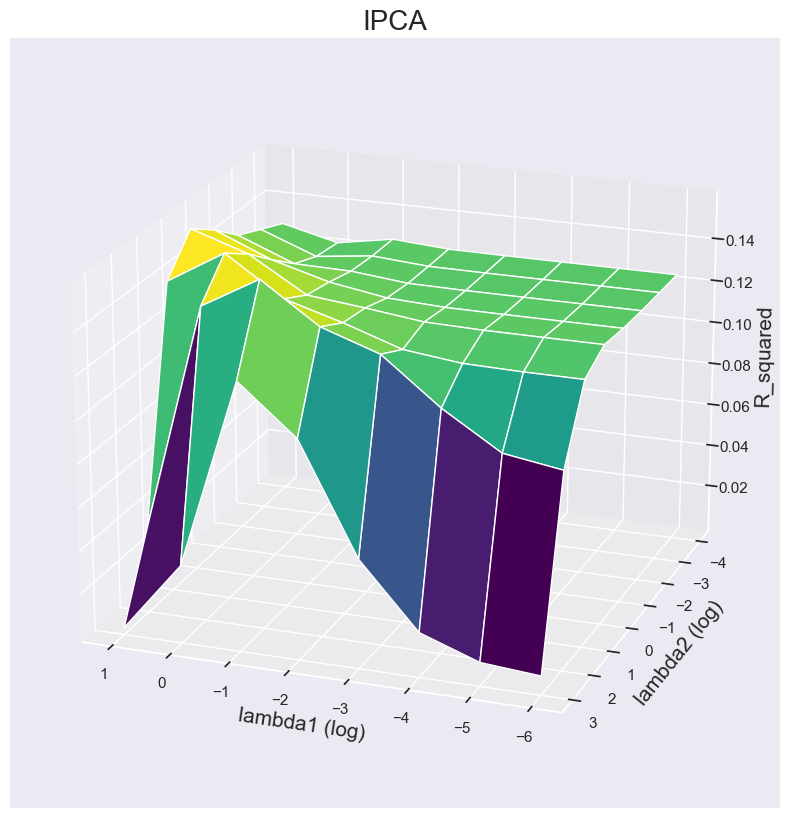

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(list([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]), list([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]))
z = val.surface_IPCA(dict_IPCA_reg, list([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]), list([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]))
ax.plot_surface(np.log10(np.array(x)), np.log10(np.array(y)), np.array(z), cmap='viridis')
ax.set_xlabel('lambda1 (log)', fontsize=15)
ax.set_ylabel('lambda2 (log)', fontsize=15)
ax.set_zlabel('R_squared', fontsize=15)
ax.set_title('IPCA', fontsize=20)
ax.view_init(20, 110)

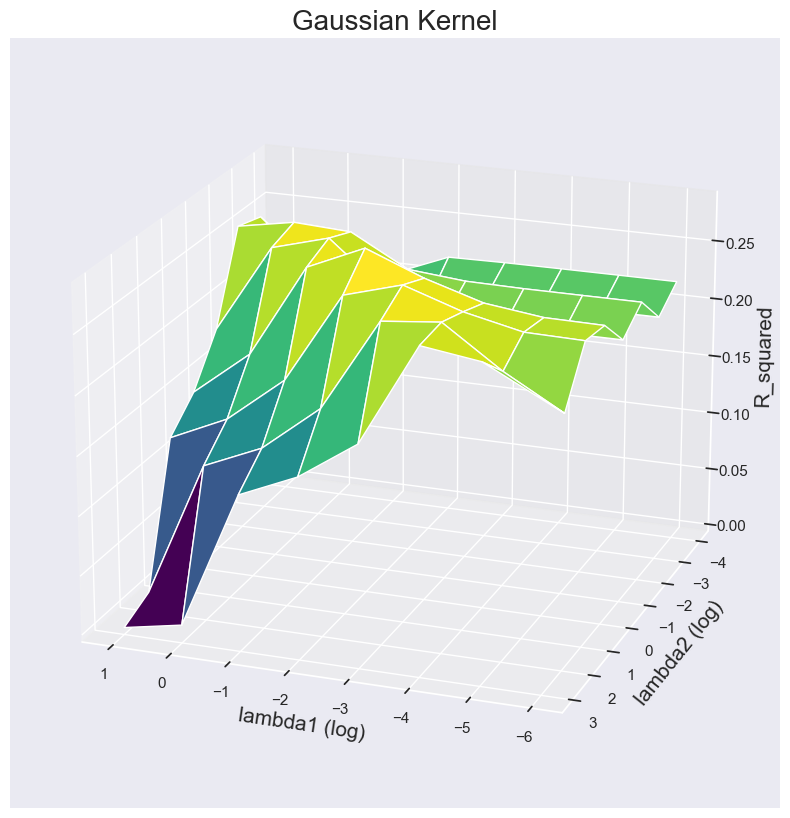

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(list([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]), list([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]))
z = val.surface_gaussian(dict_gaussian, list([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]), list([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]))
ax.plot_surface(np.log10(np.array(x)), np.log10(np.array(y)), np.array(z), cmap='viridis')
ax.set_xlabel('lambda1 (log)', fontsize=15)
ax.set_ylabel('lambda2 (log)', fontsize=15)
ax.set_zlabel('R_squared', fontsize=15)
ax.set_title('Gaussian Kernel', fontsize=20)
ax.view_init(20, 110)

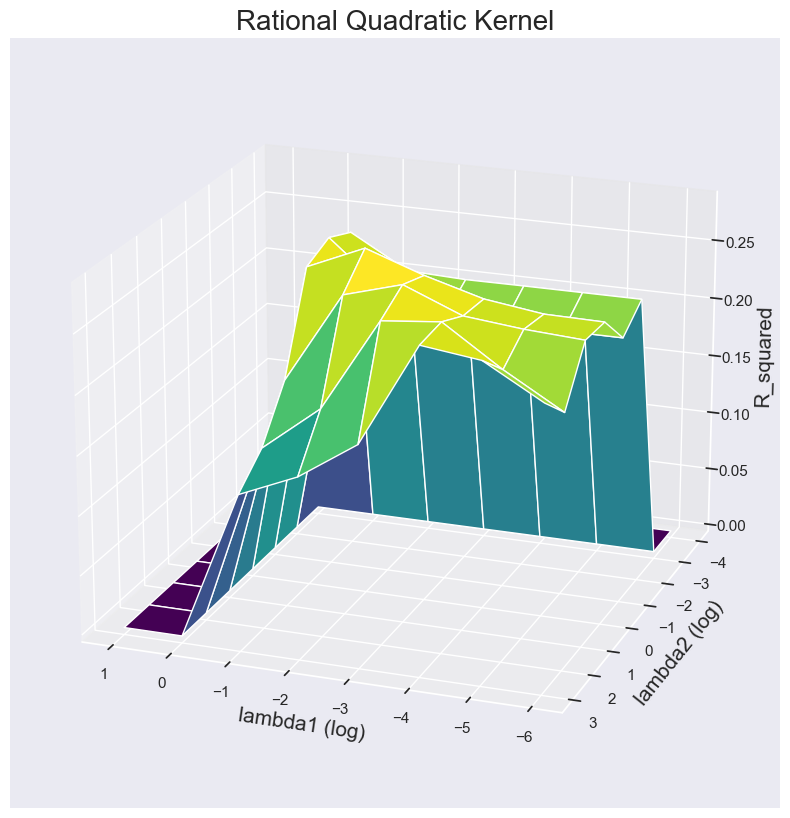

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(list([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]), list([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]))
z = val.surface_rq(dict_rq, list([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]), list([1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]))
ax.plot_surface(np.log10(np.array(x)), np.log10(np.array(y)), np.array(z), cmap='viridis')
ax.set_xlabel('lambda1 (log)', fontsize=15)
ax.set_ylabel('lambda2 (log)', fontsize=15)
ax.set_zlabel('R_squared', fontsize=15)
ax.set_title('Rational Quadratic Kernel', fontsize=20)
ax.view_init(20, 110)

### Plot the R squared out of sample using a rolling window of 5 year to estimate the model. 

In [29]:
ipca_r2 = []
ipca_reg_r2 = []
gaussian_r2 = []
rq_r2 = []

#parameters
k = 5 
trsh = 5/6
W = np.eye(N)
Omega2_inv = np.eye(N)
# we use the best parameters found in the previous section
lambdas1_reg = [0.01] 
lambdas2_reg = [1000] 
lambdas1 = [0.01]
lambdas2 = [1]
l = [20]
alpha = [20]

#loop over the time
for t in np.arange(20000000,20150000, 10000):
    data, ret = dc.download_clean_data(folder_path, t, t+60000, N)
    gamma_first = ipca.gamma_first(ret, data, k) 
    max_iter = 100
    ipca_r2.append(val.val_IPCA(ret, data, trsh, gamma_first, max_iter)['IPCA'])
    W_list = [W]*(len(data))
    ipca_reg_r2.append(val.val_IPCA_reg(ret, data, trsh, lambdas1_reg, lambdas2_reg, gamma_first, max_iter, W_list)[('IPCA_reg', 0.01, 1000)])
    max_iter = 10
    _, f_list = ipca.ipca(data, ret, gamma_first.copy(), 1)
    gaussian_r2.append(val.val_gaussian(ret, data, trsh, lambdas1, lambdas2, l, N, f_list.copy(), Omega2_inv, max_iter)[('Gaussian', 0.01, 1, 20)])
    rq_r2.append(val.val_rq(ret, data, trsh, lambdas1, lambdas2, l, alpha, N, f_list.copy(), Omega2_inv, max_iter)[('Rational Quadratic', 0.01, 1, 20, 20)])

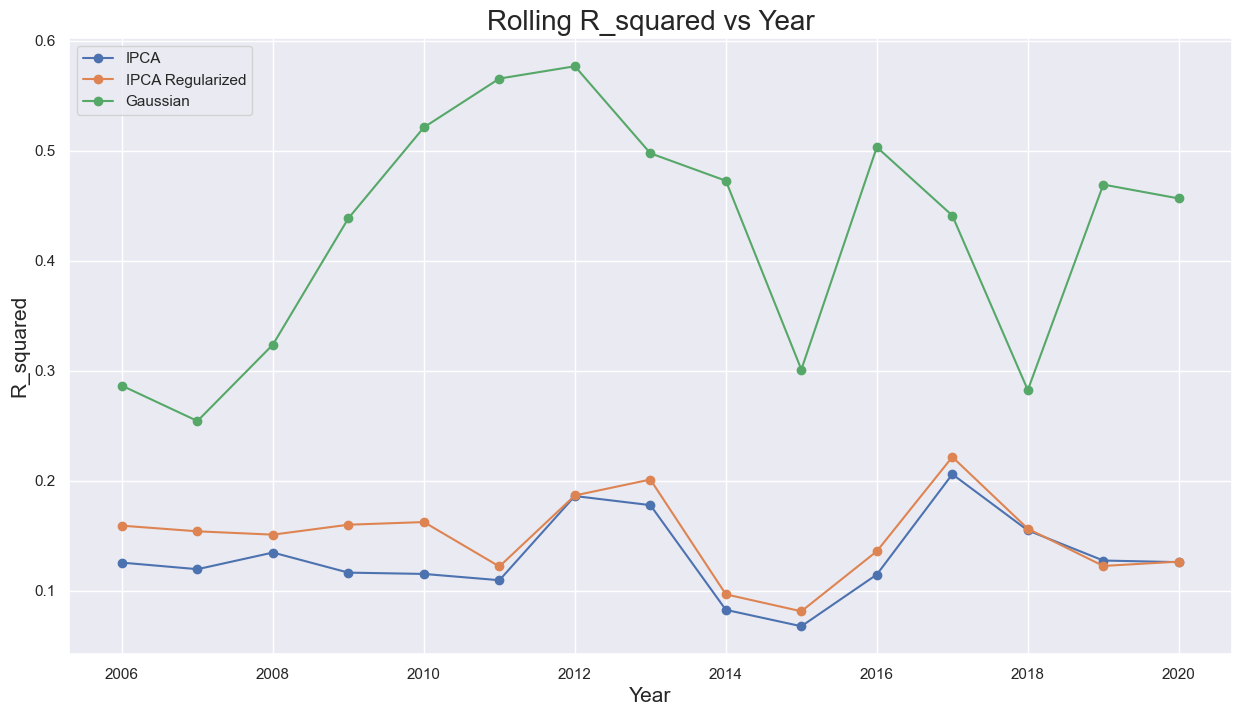

In [30]:
plt.plot(np.arange(2006,2021, 1), ipca_r2, label = 'IPCA', marker = "o")
plt.plot(np.arange(2006,2021, 1), ipca_reg_r2, label = 'IPCA Regularized', marker = "o")
plt.plot(np.arange(2006,2021, 1), gaussian_r2, label = 'Gaussian', marker = "o")
#plt.plot(np.arange(2006,2021, 1), rq_r2, label = 'Rational Quadratic', marker = "o") # equal to gaussian
plt.xlabel('Year', fontsize=15)
plt.ylabel('R_squared', fontsize=15)
plt.title('Rolling R_squared vs Year', fontsize=20)
plt.legend(loc='upper left')

### Performance of Low Rank approximation 

In [31]:
#download data for Low Rank
start_date = 20000000
ending_date = 20060000
data, ret = dc.download_clean_data(folder_path, start_date, ending_date,N)

#parameters 
k = 5
gamma_first = ipca.gamma_first(ret, data, k)
_, f_list = ipca.ipca(data, ret, gamma_first.copy(), 1)
Omega2_inv=np.eye(N)
Omega1_inv=np.eye((len(data))*N)
m_hat = 100
lambda1_g = 0.01
lambda2_g = 1
lambda1_l = 0.01 
lambda2_l = 1000 
max_iter = 10

#Low Rank Kernel Regression
data2 = data.copy()
data2 = np.array(np.array(data2).reshape((len(data))*N,94)) #flatten data, build X
K_gaussian = kr.K_LR(data2, 1, 20)
K_linear = kr.K_LR(data2, 0)
L_gaussian, B_gaussian = kr.pivoted_chol(K_gaussian, m_hat)
L_linear, B_linear = kr.pivoted_chol(K_linear, m_hat)

f_list_LR_g, v_LR_g, G_LR_g, g_LR_g = kr.kernel_regression_LR(data, K_gaussian, B_gaussian, ret, f_list.copy(), lambda1_g, lambda2_g, Omega2_inv, max_iter, m_hat, N)
f_list_LR_l, v_LR_l, G_LR_l, g_LR_l = kr.kernel_regression_LR(data, K_linear, B_linear, ret, f_list.copy(), lambda1_l, lambda2_l, Omega2_inv, max_iter, m_hat, N)
f_list_g, v_g, Q_g, _, _ = kr.kernel_regression(data, ret, f_list.copy(), lambda1_g, lambda2_g, Omega1_inv, Omega2_inv, max_iter, N, K_gaussian)
f_list_l, v_l, Q_l, _, _ = kr.kernel_regression(data, ret, f_list.copy(), lambda1_l, lambda2_l, Omega1_inv, Omega2_inv, max_iter, N, K_linear)
    
print('The norm of the difference between the two matrices divided by the norm of the gaussian kernel is : ', np.linalg.norm(L_gaussian@L_gaussian.T - K_gaussian)/np.linalg.norm(K_gaussian))
print('The norm of the difference between the two matrices divided by the norm of the linear kernel is : ', np.linalg.norm(L_linear@L_linear.T - K_linear)/np.linalg.norm(K_linear))
print('The R_squared of the model with gaussian kernel with Low Rank is : ',metrics.total_R_squared_kr_LR(ret, B_gaussian, K_gaussian, v_LR_g, f_list_LR_g))
print('The R_squared of the model with gaussian kernel is : ',metrics.total_R_squared_kr(ret, v_g, Q_g))
print('The R_squared of the model with linear kernel with Low Rank is : ',metrics.total_R_squared_kr_LR(ret, B_linear, K_linear, v_LR_l, f_list_LR_l))
print('The R_squared of the model with linear kernel is : ',metrics.total_R_squared_kr(ret, v_l, Q_l))

The norm of the difference between the two matrices divided by the norm of the gaussian kernel is :  0.011779723707680852
The norm of the difference between the two matrices divided by the norm of the linear kernel is :  3.043159867438002e-15
The R_squared of the model with gaussian kernel with Low Rank is :  0.34958790681962026
The R_squared of the model with gaussian kernel is :  0.5830609572491796
The R_squared of the model with linear kernel with Low Rank is :  0.1628977161221732
The R_squared of the model with linear kernel is :  0.32268606572801495
